### Task 1: Calculate Global Moran's I for wasted votes in Dane County, WI for Democrats in presidential election 2020

The below snippet is outsourced from Geopandas documentation - <a href = "https://geopandas.org/en/stable/getting_started/install.html"> click here </a>

In [175]:
# helps in reading geojson files without resorting to value errors
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [174]:
# import all required libraries
import esda, json, os
import pandas as pd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely import Point
%matplotlib inline

Downloaded data from <a href = "https://data-ltsb.opendata.arcgis.com/datasets/LTSB::2012-2020-election-data-with-2020-wards/explore"> Wisconsin State Legislature Website </a>

<AxesSubplot:>

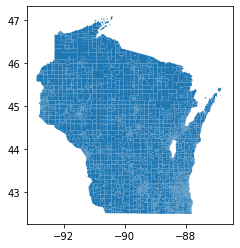

In [14]:
# reading geojson downloaded from opendata portal
wi_gdf = gpd.read_file(r"2012-2020_Election_Data_with_2020_Wards.geojson")
wi_gdf.plot()

In [16]:
# selecting Dane County to perform calculations
dane_county= gdf[(gdf['CNTY_NAME']=='Dane')]
dane_county.head(1)

,OBJECTID,GEOID,CNTY_FIPS,CNTY_NAME,COUSUBFP,MCD_FIPS,MCD_NAME,CTV,LABEL,LSAD,...,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,geometry
818,819,55025008750001,55025,Dane,00875,5502500875,Albion,T,Albion - T 0001,43,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-89.04186 42.86069, -89.04260 42.861..."


Text(0.5, 1.0, 'Election wards 2022 Dane County, WI')

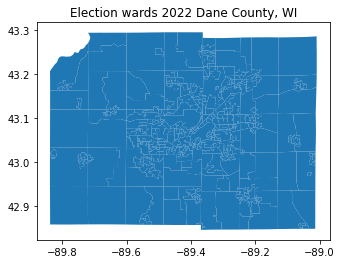

In [20]:
dane_county.plot()
plt.title("Election wards 2022 Dane County, WI")

In [35]:
# replacing all NaN values with zero
dane_county = dane_county.fillna(0)

<b>Variables in each voting district (WARD)</b>
<ul>
<li>Democratic Votes: <b>PREDEM20</b></li>
<li>Republican Votes: <b>PREREP20</b></li>
<li>Total Votes: <b>PRETOT20</b></li>
</ul>

In [73]:
# calculates number of polled votes
def polled_votes(row):
    return (row['PREDEM20'] + row['PREREP20'])

# calculates Democrat voting percentage for a given ward based on polled votes
def dem_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREDEM20']/row['TOTP_VOT'])*100
        return round(result,2)
    else:
        return 0

# calculates Republican voting percentage for a given ward based on polled votes
def rep_voters(row):
    if not row['PRETOT20'] == 0:
        result = (row['PREREP20']/row['TOTP_VOT'])*100
        return round(result,2)
    else: 
        return 0

In [74]:
dane_county['TOTP_VOT'] = dane_county.apply(lambda row: polled_votes(row), axis = 1)
dane_county['DEM_PCT'] = dane_county.apply(lambda row: dem_voters(row), axis = 1)
dane_county['REP_PCT'] = dane_county.apply(lambda row: rep_voters(row), axis = 1)

What is wasted vote - <a href = "https://ballotpedia.org/Efficiency_gap"> Ballotpedia Blog </a>

In [81]:
# calculates Democrat wasted votes for a given ward based on polled votes
def dem_wasted_votes(row):
    if row['DEM_PCT'] >= 50.1:
        excess_pct = (row['DEM_PCT']-50.1)
        if excess_pct > 0:
            wasted_votes = (excess_pct/100)*row['TOTP_VOT']
            return round(wasted_votes)
        else: 
            return 0
    else:
        return 0
    
dane_county['DEM_WST_VOT'] = dane_county.apply(lambda row: dem_wasted_votes(row), axis = 1)

In [83]:
# printing data frame to understand calculations
dane_df = dane_county[['GEOID', 'CNTY_NAME', 'MCD_NAME', 'PREDEM20', \
                       'PREREP20', 'PRETOT20', 'DEM_PCT', 'REP_PCT', \
                       'TOTP_VOT', 'DEM_WST_VOT']]
dane_df

,GEOID,CNTY_NAME,MCD_NAME,PREDEM20,PREREP20,PRETOT20,DEM_PCT,REP_PCT,TOTP_VOT,DEM_WST_VOT
818,55025008750001,Dane,Albion,323.0,288.0,624.0,52.86,47.14,611.0,17
819,55025008750002,Dane,Albion,340.0,302.0,654.0,52.96,47.04,642.0,18
820,55025063000001,Dane,Belleville,443.0,196.0,655.0,69.33,30.67,639.0,123
821,55025063000002,Dane,Belleville,429.0,189.0,630.0,69.42,30.58,618.0,119
822,55025070250001,Dane,Berry,176.0,135.0,316.0,56.59,43.41,311.0,20
...,...,...,...,...,...,...,...,...,...,...
1301,55025515750022,Dane,Middleton,0.0,0.0,0.0,0.00,0.00,0.0,0
1302,55025776750016,Dane,Stoughton,0.0,0.0,0.0,0.00,0.00,0.0,0
1303,55025786000027,Dane,Sun Prairie,0.0,0.0,0.0,0.00,0.00,0.0,0
1304,55025877250010,Dane,Windsor,354.0,202.0,564.0,63.67,36.33,556.0,75


In [89]:
y = dane_county['DEM_WST_VOT'] # target variable
wq =  lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.4855127911687452

Text(0.5, 0, "Moran's I")

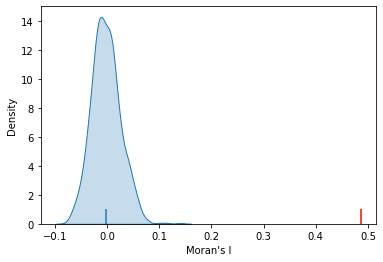

In [92]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r') # observed value
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

### Task 2: Calculation Local Moran's I for Dane County, WI - Hotspots & Coldspots

The code below is borrowed from PySAL documentation - <a href = "https://pysal.org/esda/notebooks/spatialautocorrelation.html"> click here </a>

C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "multilinestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:30: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use th

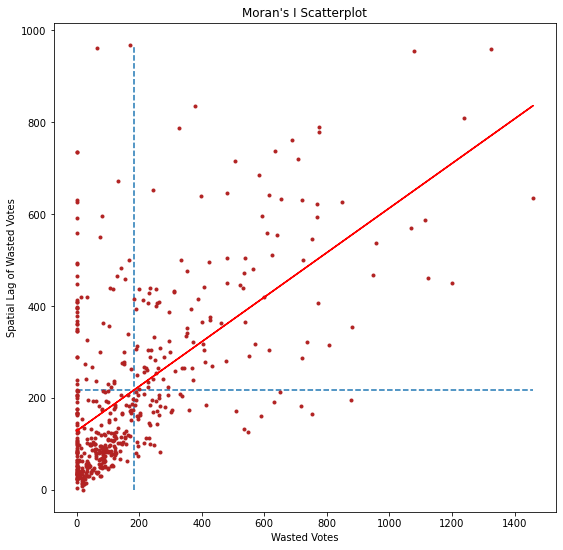

In [153]:
y = dane_county['DEM_WST_VOT'] # target variable
wq = lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
lag_wasted_votes = lps.weights.lag_spatial(wq, dane_county['DEM_WST_VOT'])
wasted_votes = dane_county['DEM_WST_VOT']
b, a = np.polyfit(wasted_votes, lag_wasted_votes, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(wasted_votes, lag_wasted_votes, '.', color='firebrick')

 # dashed vert at mean of wasted votes
plt.vlines(wasted_votes.mean(), lag_wasted_votes.min(), lag_wasted_votes.max(), linestyle='--')
 # dashed horizontal at mean lagged wasted votes
plt.hlines(lag_wasted_votes.mean(), wasted_votes.min(), wasted_votes.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(wasted_votes, a + b*wasted_votes, 'r')
plt.title("Moran's I Scatterplot")
plt.ylabel('Spatial Lag of Wasted Votes')
plt.xlabel('Wasted Votes')
plt.show()

In [123]:
li = esda.moran.Moran_Local(y, wq)

In [124]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 0, 0, 3, 3, 0, 0, 3, 2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0,
       3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0,
       0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 3, 3, 3, 3, 3,

In [125]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

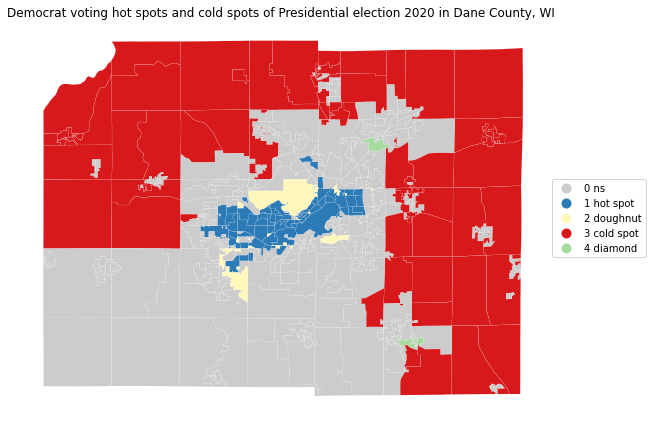

In [152]:
df = dane_county
from matplotlib import colors
hmap = colors.ListedColormap([ '#cccccc', '#2c7bb6', '#fff7bc', '#d7191c', '#a6dba0'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_axis_off()
plt.title('Democrat voting hot spots and cold spots of Presidential election 2020 in Dane County, WI ')
plt.tight_layout()

In [154]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib as mpl

C:\Users\Sidrcs\AppData\Local\Temp/ipykernel_15032/3170509294.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  austin_gdf.centroid.plot(ax=ax, c='gray')


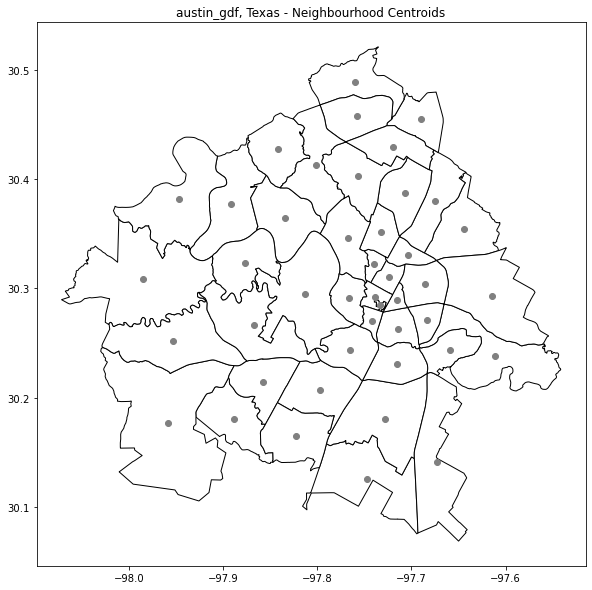

In [221]:
austin_gdf = gpd.read_file('neighbourhoods.geojson')
austin_gdf = austin_gdf.set_crs('EPSG:4326', allow_override=True)

fig, ax = plt.subplots(figsize=(10,10))
austin_gdf.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
austin_gdf.centroid.plot(ax=ax, c='gray')
plt.title('austin_gdf, Texas - Neighbourhood Centroids')
plt.show()

In [222]:
austin_gdf.head()

,neighbourhood,neighbourhood_group,geometry
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ..."
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ..."
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ..."
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ..."


In [223]:
# load the house listing point data using pandas 
bl_df = pd.read_csv('listings.csv.gz',compression='gzip')
bl_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20230316044216,2023-03-16,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.82,4.73,4.79,NaN,f,2,2,0,0,3.69
1,5769,https://www.airbnb.com/rooms/5769,20230316044216,2023-03-16,previous scrape,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.76,4.92,NaN,f,1,0,1,0,1.75
2,6413,https://www.airbnb.com/rooms/6413,20230316044216,2023-03-16,previous scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.76
3,6448,https://www.airbnb.com/rooms/6448,20230316044216,2023-03-16,city scrape,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/4513152/4ffc1...,14156,...,4.97,4.97,4.90,NaN,t,1,1,0,0,2.10
4,8502,https://www.airbnb.com/rooms/8502,20230316044216,2023-03-17,city scrape,Woodland Studio Lodging,Studio rental on lower level of home located i...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,...,4.86,4.64,4.57,NaN,f,1,1,0,0,0.30


In [224]:
# read geometry from csv file and convert values in Point(XY) using Shapely.Point
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]

# create a geodataframe based on dataframe and geometry
bl_gdf = gpd.GeoDataFrame(bl_df, geometry=geometry)
bl_gdf=bl_gdf.set_crs(crs='EPSG:4326')

#print columns
print(bl_gdf.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [225]:
bl_gdf.head(1)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,5456,https://www.airbnb.com/rooms/5456,20230316044216,2023-03-16,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.73,4.79,NaN,f,2,2,0,0,3.69,POINT (-97.73441 30.26057)


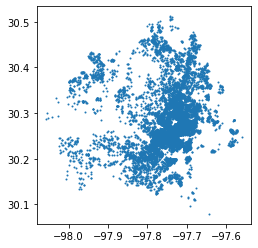

In [226]:
bl_gdf.plot(markersize = 1)
plt.show()

In [227]:
bl_gdf['price']=bl_gdf['price'].str.replace('$','')
bl_gdf['price']=bl_gdf['price'].str.replace(',','')
bl_gdf.head(1)

C:\Users\Sidrcs\AppData\Local\Temp/ipykernel_15032/694336847.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bl_gdf['price']=bl_gdf['price'].str.replace('$','')


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,5456,https://www.airbnb.com/rooms/5456,20230316044216,2023-03-16,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.73,4.79,NaN,f,2,2,0,0,3.69,POINT (-97.73441 30.26057)


In [228]:
# check if NaNs are present in price
bl_gdf['price'] = bl_gdf['price'].astype('float32')
bl_gdf['price'].describe()

count    14368.000000
mean       310.029938
std        798.368774
min          0.000000
25%        108.000000
50%        180.000000
75%        320.000000
max      65155.000000
Name: price, dtype: float64

In [229]:
bl_gdf['neighbourhood_cleansed']

0        78702
1        78729
2        78704
3        78704
4        78741
         ...  
14363    78705
14364    78705
14365    78705
14366    78734
14367    78741
Name: neighbourhood_cleansed, Length: 14368, dtype: int64

In [232]:
# process the data and compute the median house price per neighborhood polygon  
# compute mean of other explainable variables 

sj_gdf = gpd.sjoin(austin, bl_gdf, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_cleansed']]).median()
print(type(median_price_gb))
median_price_gb

<class 'pandas.core.series.Series'>


neighbourhood_cleansed
78701     279.0
78702     232.0
78703     250.0
78704     203.0
78705     141.0
78712    1035.0
78717     110.0
78719      90.0
78721     180.5
78722     170.0
78723     162.0
78724     135.0
78725     175.0
78726     154.0
78727     125.0
78728     109.0
78729     124.5
78730     245.0
78731     250.0
78732     350.0
78733     317.0
78734     297.0
78735     170.5
78736     183.5
78737     245.5
78738     158.0
78739     256.0
78741     131.0
78742     146.0
78744     130.5
78745     158.0
78746     385.0
78747     104.5
78748     128.0
78749     150.0
78750     127.0
78751     121.0
78752     110.5
78753     118.5
78754     100.0
78756     134.0
78757     149.0
78758     129.0
78759     140.0
Name: price, dtype: float32

,neighbourhood,neighbourhood_group,geometry,median_pri
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",256.0
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",100.0
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",350.0
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",245.5
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",134.0
5,78747,None,"MULTIPOLYGON (((-97.73617 30.15986, -97.73591 ...",104.5
6,78751,None,"MULTIPOLYGON (((-97.70677 30.32211, -97.70693 ...",121.0
7,78712,None,"MULTIPOLYGON (((-97.73366 30.28536, -97.73295 ...",1035.0
8,78738,None,"MULTIPOLYGON (((-98.00622 30.36079, -98.00424 ...",158.0
9,78725,None,"MULTIPOLYGON (((-97.62338 30.26459, -97.62126 ...",175.0


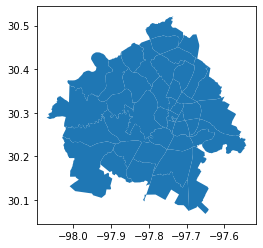

In [233]:
median_price_gb.rename("neighbourhood")
median_price_gb.index = median_price_gb.index.map(str) ## ensure the index key has the same data type of string
austin_gdf['neighbourhood'] = austin_gdf['neighbourhood'].astype('string')
austin_gdf = austin_gdf.join(median_price_gb, on='neighbourhood')
austin_gdf.rename(columns={'price': 'median_pri'}, inplace=True)
austin_gdf.plot()
austin_gdf

0
0


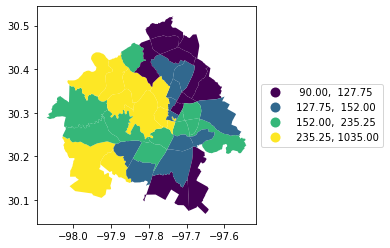

In [235]:
# check the neighborhood with 'NAN' values
# fill the NAN values with median prices
# More color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

print(pd.isnull(austin_gdf['median_pri']).sum())
austin_gdf['median_pri'].fillna((austin_gdf['median_pri'].median()), inplace=True)

ax = austin_gdf.plot(column='median_pri', scheme='QUANTILES', k=4, \
             cmap='viridis', legend=True,
             legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

print(pd.isnull(austin_gdf['median_pri']).sum())